# Predictive model

In [1]:
from pathlib import Path
from os import chdir
if not 'this_path' in locals(): this_path = Path.cwd()
chdir(this_path.parent)

In [14]:
data = model.dataset.copy()

In [2]:
from inspect_tables import read_data, overview
import re
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from dataset_generator import fornitori, binder_dt, failure_list, get_timeseries, full_categories
idx = pd.IndexSlice

## Primo approccio esplorativo

Predizione di guasto su un Dataset sintetico che assuma tutte le fatture associate a un unico veicolo. Ogni fattura viene presentata al modello con un periodo $\Delta t$ di misiurazioni antecedente al guasto.
- $\Delta t$ viene posto a **1 mese**
- I dati sono al momento aggregati per ottenere **1 sample** al giorno (questa fase necessiterà di feature engineering)

Predire:
 1. Un guasto preso singolarmente (es. il più numeroso)
 2. Tutte le categorie insieme (i.e. predire una rottura qualsiasi)
 3. Modello multiclasse
 
 Modelli da testare:
  - XGBoost
  - Random Forest
  - LSTM
  - ...

## Selezione Fatture

Da queste fatture vogliamo eliminare tutte quelle che hanno una fattura dello stesso tipo su quel veicolo entro un periodo di **7 giorni**

Numero di fatture totali: 208 (considerate: 150)


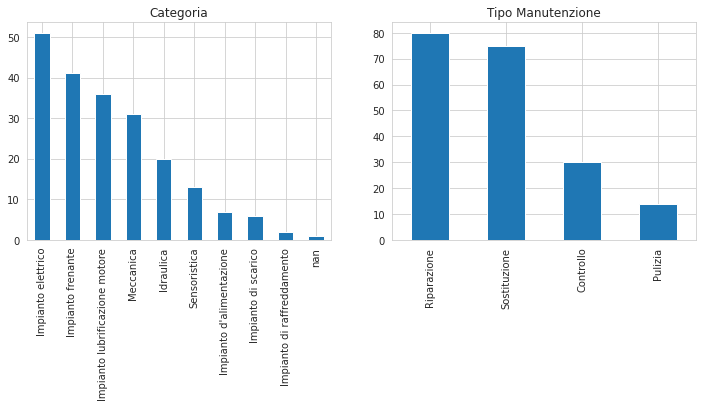

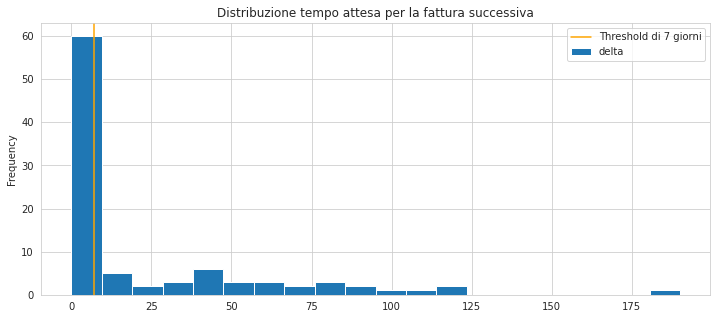

In [4]:
kept_fatture = failure_list(dt=7, verbose=True)

⚠️ Valutare se considerare solo alcune di queste tipologie di manutenzione

⚠️ **Il mese considerato non deve contenere altre rotture**
Tutte le fatture (di qualsiasi tipologia) che avvengono prima di $\Delta t$ dalla rottura precedente velgono ulteriormente rimosse.

**Assunzione:** Le fatture dello stesso giorno ma di tipologia diversa vengono per il momento mantenute, nel caso del modello a classe singola se ne potrebbe considerare solo una per ogni data

## Costruzione Dataset

A partire dai dati dei 3 fornitori principali, si possono definire le serie temporali che tengano informazioni su, min, max, media, count, percentili:

|                     | Movimatica     | Scania            |  Visirun   |
| -----------         | :---------:    | :---------:       | :------:   |
| **odometro**        | odometer       | Odometer          | odometer   |
| **velocità**        | position_speed | AverageSpeed      | speed      |
| **tempo attività**  | engineHours    | EngineRunningTime | workMinutes|

 - Aggregation **giornaliera**
 - Nel caso di più fornitori: merge
 - Feature selection con pearson-correlation (> $thr$)

| Movimatica: (30678, 6) |


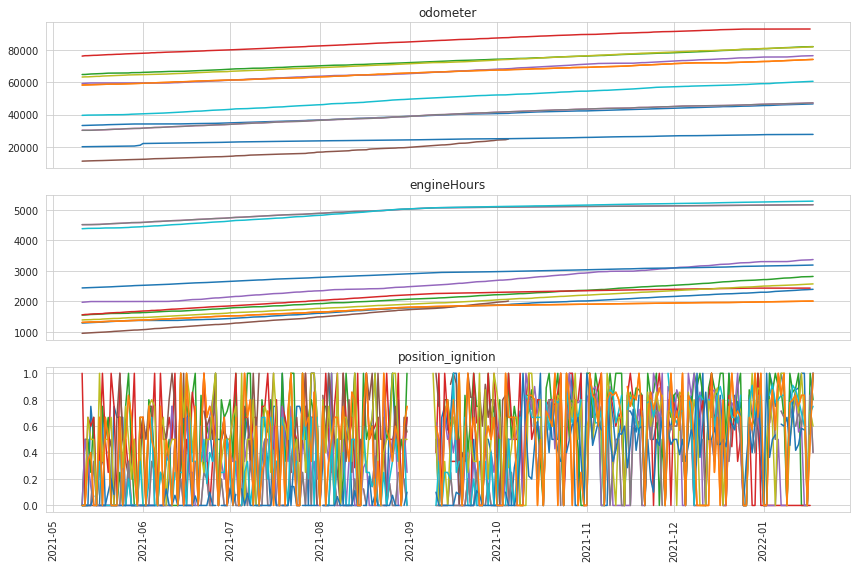

In [24]:
df_mov = binder_dt("Movimatica", fornitori.Movimatica, debug=True)

| Visirun: (12484, 6) |


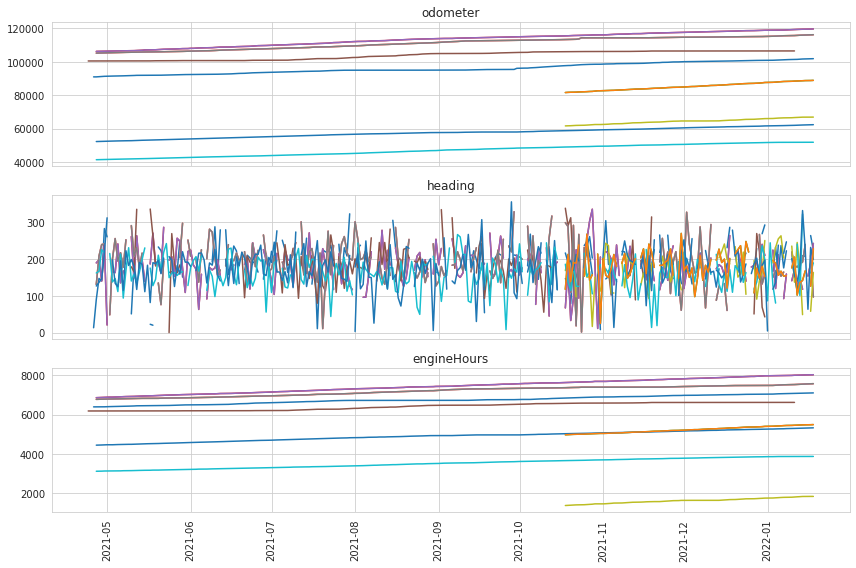

In [25]:
df_vis = binder_dt("Visirun", curr_f=fornitori.Visirun, debug=True)

---
## Feature Engineering and Selection

In [8]:
ds = data

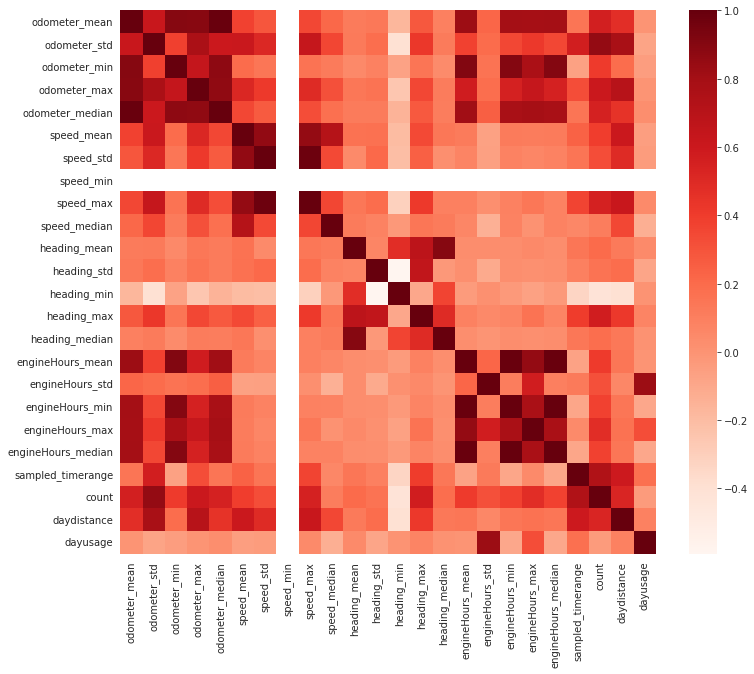

In [73]:
plt.figure(figsize=(12,10))
corr = ds.corr()
sns.heatmap(corr, cmap=plt.cm.Reds)
plt.show()

---
## Approccio esplorativo

- sequenziare coppie + numerose
- plottare l'andamento (tirare fuori solo le 'serie')
- dato `hot_period` fisso, valutare dove fare lo split
    - Al momento, manualmente, è fisso a 30 giorni prima dell'ultima fattura

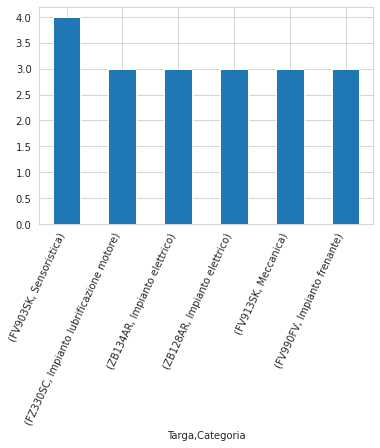

In [29]:
tmp = kept_fatture.groupby(["Targa", "Categoria"]).ID.count().sort_values(ascending=False)
g = tmp[tmp > 2].plot(kind="bar", rot=75)
g.set_xticklabels(g.get_xticklabels(), rotation=65, ha='right')
plt.show()

  📂  Loading 'Movimatica...'


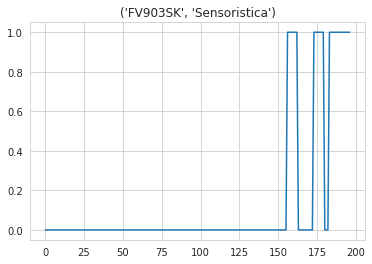

  📂  Loading 'Movimatica...'


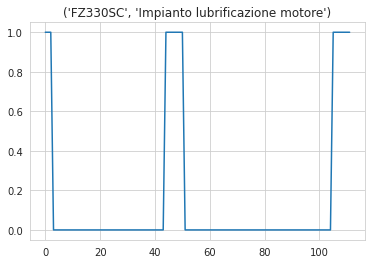

  📂  Loading 'Movimatica...'


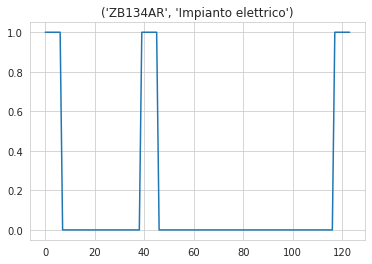

  📂  Loading 'Movimatica...'


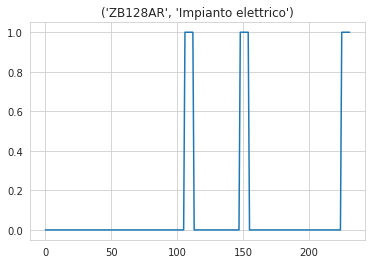

  📂  Loading 'Movimatica...'


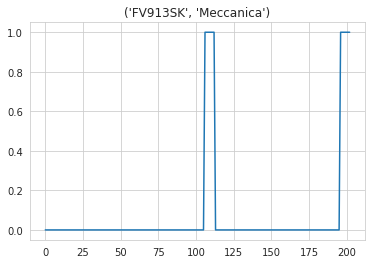

In [53]:
for couple in tmp[tmp > 2].index:
    if couple[0] in df_mov.index.get_level_values(0):
        ds = get_timeseries(dt=7, limit_plate=couple[0], limit_cat=couple[1])
        plt.plot(ds.date, ds.attended_failure)
        plt.title(couple)
        plt.show()

In [10]:
dataset = get_timeseries(limit_plate="ZB478AN", limit_provider="Visirun")

  📂  Loading 'Visirun'...
Only considering (ZB478AN, Any)
10 features are excluded because too correlated with others ({'heading_median', 'engineHours_max', 'odometer_max', 'odometer_median', 'speed_max', 'count', 'engineHours_median', 'speed_std', 'odometer_min', 'engineHours_min'})


In [4]:
from lstm_model import train
couples = [
    ('FZ330SC', 'Impianto lubrificazione motore'),
    ('ZB134AR', 'Impianto elettrico'),
    ('ZB128AR', 'Impianto elettrico'),
    ('FV913SK', 'Impianto elettrico'),
]

for pl, cat in couples:
    train(pl, cat)

Global seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


  📂  Loading 'Movimatica'...


/home/students/s265780/.local/lib/python3.7/site-packages/pytorch_lightning/loggers/csv_logs.py:58: UserWarning: Experiment logs directory ./logs/lstm_FZ330SC_Impianto lubrificazione motore/0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  f"Experiment logs directory {self.log_dir} exists and is not empty."

  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | lstm      | LSTM              | 131 K 
2 | linear    | Linear            | 101   
------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.527     Total estimated model params size (MB)


Only considering (FZ330SC, ['Impianto lubrificazione motore'])


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 1
/home/students/s265780/.local/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Global seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


  📂  Loading 'Movimatica'...



  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | lstm      | LSTM              | 131 K 
2 | linear    | Linear            | 101   
------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.527     Total estimated model params size (MB)


Only considering (ZB134AR, ['Impianto elettrico'])


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 1
/home/students/s265780/.local/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Global seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


  📂  Loading 'Movimatica'...



  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | lstm      | LSTM              | 131 K 
2 | linear    | Linear            | 101   
------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.527     Total estimated model params size (MB)


Only considering (ZB128AR, ['Impianto elettrico'])


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 1
/home/students/s265780/.local/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (42) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/students/s265780/.local/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
Global seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


  📂  Loading 'Movimatica'...


/home/students/s265780/.local/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


---

# ML Model

In [8]:
! python lstm_model.py -t regression

Traceback (most recent call last):
  File "lstm_model.py", line 185, in <module>
    train()
TypeError: train() missing 1 required positional argument: 'hparams'


In [64]:
df = df_mov.reset_index()
df = df.assign(factor=df.plate.factorize()[0])[["plate", "factor"]].drop_duplicates()

df[df.plate.isin(["FZ330SC","ZB134AR","ZB128AR","FV913SK"])]

,plate,factor
1264,FV913SK,5
3835,FZ330SC,16
4237,ZB128AR,18
5239,ZB134AR,22


In [27]:
logs.describe()

,train_loss_step,train_acc_step,epoch,step,val_loss_step,val_acc_step,val_loss_epoch,val_acc_epoch,train_loss_epoch,train_acc_epoch
count,630.000000,630.0,660.000000,705.000000,45.000000,45.0,15.000000,15.0,15.000000,15.0
mean,0.314366,0.0,7.000000,296.702128,2.335901,0.0,2.335901,0.0,0.314366,0.0
std,0.667013,0.0,4.323771,190.214993,0.128310,0.0,0.131312,0.0,0.051307,0.0
min,0.013717,0.0,0.000000,0.000000,2.271660,0.0,2.273109,0.0,0.298062,0.0
25%,0.079826,0.0,3.000000,125.000000,2.289131,0.0,2.290040,0.0,0.299049,0.0
50%,0.094429,0.0,7.000000,293.000000,2.305475,0.0,2.306656,0.0,0.301147,0.0
75%,0.104829,0.0,11.000000,461.000000,2.323053,0.0,2.323017,0.0,0.303624,0.0
max,4.478179,0.0,14.000000,629.000000,2.808982,0.0,2.806093,0.0,0.499567,0.0


In [90]:
from inspect_tables import veicoli
import json
import torch

In [16]:
from lstm_model import truckLSTM, hparams
from dataset_generator import get_timeseries, FailureDataset

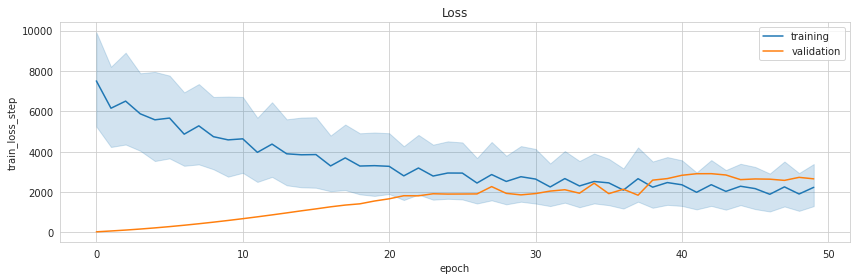

In [121]:
fig, ax = plt.subplots(figsize=(12, 4))
logs = pd.read_csv("logs/lstm_reg/v0/metrics.csv")
# logs = logs[logs.epoch < 30]
sns.lineplot(data=logs, x="epoch", y="train_loss_step", ax=ax, label="training")
sns.lineplot(data=logs, x="epoch", y="val_loss_epoch", ax=ax, label="validation")
ax.set_title("Loss")

# sns.lineplot(data=logs, x="epoch", y="train_mse_epoch", ax=ax[1], label="training")
# # sns.lineplot(data=logs, x="epoch", y="val_acc_epoch", ax=ax[1], label="validation")
# ax[1].legend()
# ax[1].set_title("MSE")

# fig.suptitle(log.stem)
plt.tight_layout()
plt.show()

In [22]:
dataset = get_timeseries(dt=10, hot_period=hparams.hot_period, limit_provider='Movimatica', use_rul=True)

  📂  Loading 'Movimatica'...


In [111]:
dataset

,plate,date,odometer_mean,odometer_std,speed_mean,speed_min,speed_max,speed_median,heading_mean,heading_std,heading_min,heading_max,engineHours_mean,engineHours_std,engineHours_max,sampled_timerange,count,dayusage,RUL
0,0,0,0.000000,7.102796,11.133333,0.0,33.4,0.0,74.593333,21.363877,58.04,98.71,0.000000,0.000000,0.000000,2.0,3,0.000000,136.0
1,0,1,28.681000,8.183634,7.900000,0.0,35.1,0.0,151.835714,131.334844,16.79,330.15,2.550000,0.000000,2.550000,6.0,7,0.000000,135.0
2,0,2,22.173429,3.635421,2.414286,0.0,15.2,0.0,105.122857,110.530073,36.82,342.30,3.173810,0.768528,4.916667,4.0,7,2.033333,134.0
3,0,3,13.228905,4.243814,1.933333,0.0,5.8,0.0,52.686667,86.769972,2.59,152.88,2.292857,0.952628,1.650000,0.0,3,1.650000,133.0
4,0,4,1.226333,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00,0.550000,0.000000,0.000000,0.0,0,0.825000,132.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2856,14,115,133.797500,40.161180,7.081818,0.0,32.1,0.0,143.267273,91.410762,20.82,344.26,8.831818,2.371889,15.983333,8.0,11,7.866667,4.0
2857,14,116,28.090000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00,3.575758,0.000000,0.000000,0.0,0,3.933333,3.0
2858,14,117,28.090000,0.000000,0.000000,0.0,0.0,0.0,36.840000,0.000000,36.84,36.84,3.575758,0.000000,0.000000,0.0,1,0.000000,2.0
2859,14,118,84.626909,46.540531,12.872727,0.0,58.2,3.5,181.742727,93.973032,17.41,319.97,0.000000,0.000000,0.000000,11.0,11,0.000000,1.0


In [23]:
model = truckLSTM.load_from_checkpoint("logs/lstm_reg/0/checkpoints/epoch=9-step=8919-v1.ckpt", hparams=hparams, dataset=dataset)
model.eval()

RuntimeError: Error(s) in loading state_dict for truckLSTM:
	size mismatch for lstm.weight_ih_l0: copying a param with shape torch.Size([400, 18]) from checkpoint, the shape in current model is torch.Size([400, 17]).

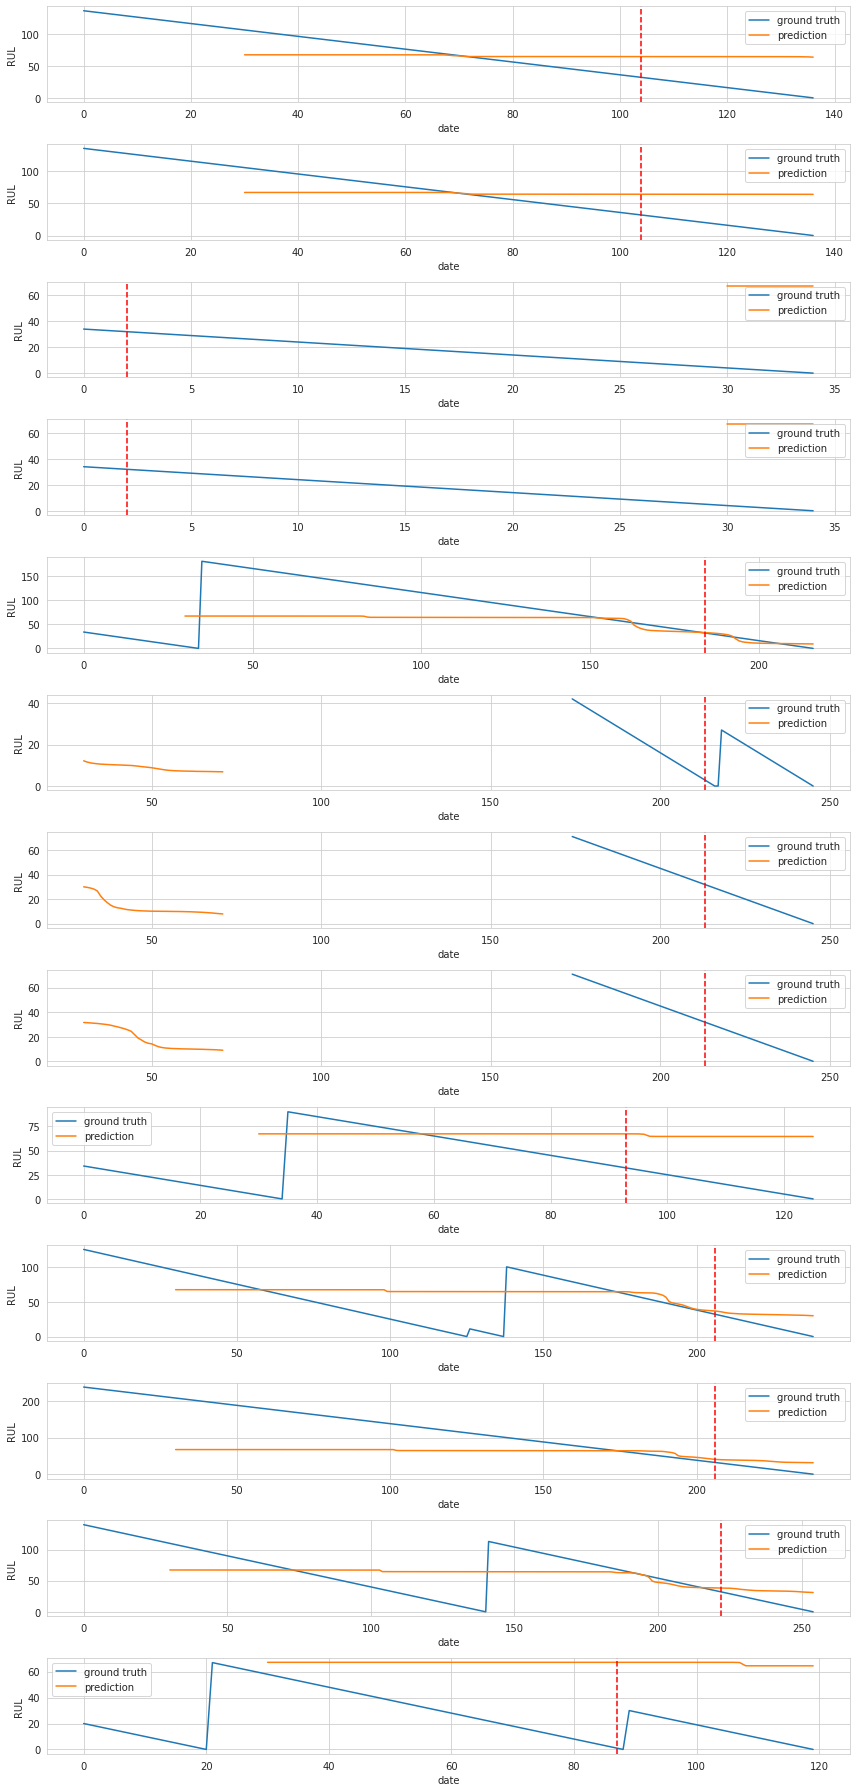

In [128]:
fig, ax = plt.subplots(len(dataset.plate.unique()), 1, figsize=(12,25))
with torch.no_grad():
#     for i, plate in enumerate([5, 16, 18, 22]):
    for i, plate in enumerate(dataset.plate.unique()):
        torch_ds = FailureDataset(dataset[dataset.plate == plate], label_col="RUL")
        prediction = []
        for x, y in torch_ds:
            y_hat = model(x.unsqueeze(0)).squeeze()
            prediction.append(y_hat.detach().numpy())


        sns.lineplot(data=dataset[dataset.plate==plate], x="date", y="RUL", ax=ax[i], label="ground truth")
        ax[i].plot(np.arange(30, len(prediction)+30), prediction, label="prediction")
        ax[i].axvline(dataset[dataset.plate==plate].date.max()-32, ls='--', c='r')
        ax[i].legend()
        
plt.tight_layout()
plt.show()

---

/home/students/s265780/.local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1376: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


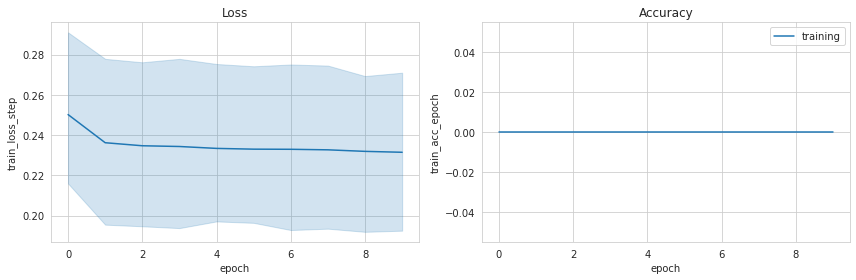

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
logs = pd.read_csv("logs/lstm/fullnorm/metrics.csv")
logs = logs[logs.epoch < 30]
sns.lineplot(data=logs, x="epoch", y="train_loss_step", ax=ax[0])
sns.lineplot(data=logs, x="epoch", y="val_loss_step", ax=ax[0])
ax[0].set_title("Loss")

sns.lineplot(data=logs, x="epoch", y="train_acc_epoch", ax=ax[1], label="training")
# sns.lineplot(data=logs, x="epoch", y="val_acc_epoch", ax=ax[1], label="validation")
ax[1].legend()
ax[1].set_title("Accuracy")

# fig.suptitle(log.stem)
plt.tight_layout()
plt.show()

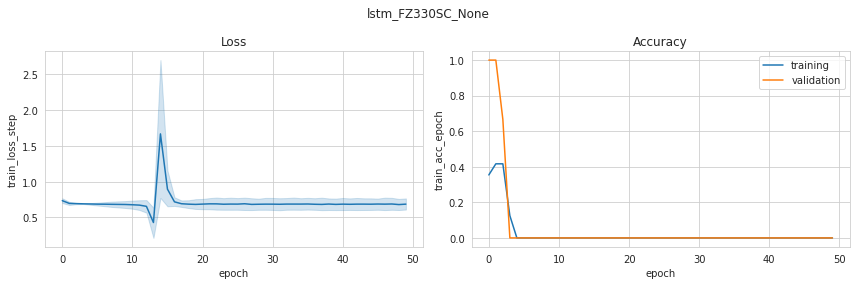

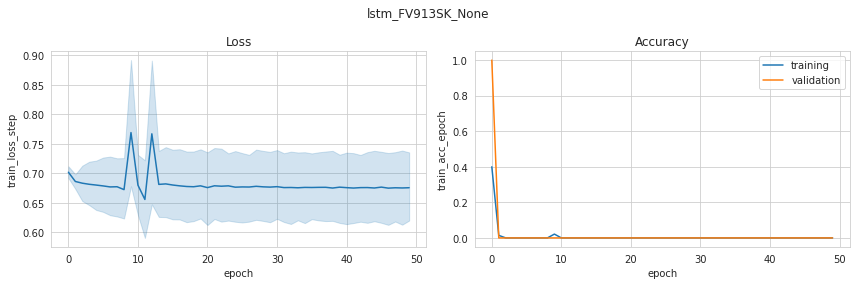

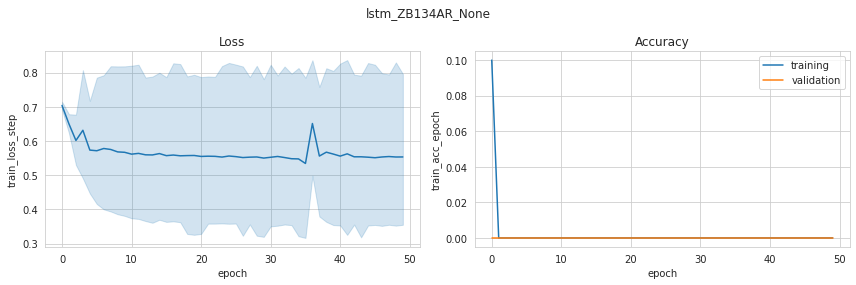

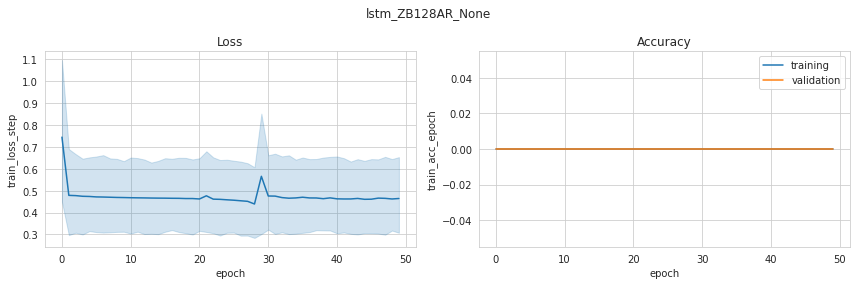

In [31]:
log_dir = Path("logs/")

for i, log in enumerate(log_dir.iterdir()):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    logs = pd.read_csv(log / "1/metrics.csv")
    sns.lineplot(data=logs, x="epoch", y="train_loss_step", ax=ax[0])
    sns.lineplot(data=logs, x="epoch", y="val_loss_step", ax=ax[0])
    ax[0].set_title("Loss")

    sns.lineplot(data=logs, x="epoch", y="train_acc_epoch", ax=ax[1], label="training")
    sns.lineplot(data=logs, x="epoch", y="val_acc_epoch", ax=ax[1], label="validation")
    ax[1].legend()
    ax[1].set_title("Accuracy")
    
    fig.suptitle(log.stem)
    plt.tight_layout()
    plt.show()